# Notebook to examine putative summation in power muscle EMG signal

What we previously attributed to noise -- a 'ripple' in the power muscle spikes -- might actually be evidence of a motor neuron firing in a burst and creating a summed signal for the measured EMG.

Want to determine:
  1) if the ripples on the spikes can be meaningfully separated from the noise elsewhere in the signal
  2) if we can deconvolve the signal to get spike time estimates

## Imports

In [116]:
import os 
import pickle

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from mosquito.util import idx_by_thresh, butter_highpass_filter
from mosquito.process_abf import load_processed_data

## Set params

In [117]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


In [118]:
# for spike peak detection
MIN_PROMINENCE = 3e-2  # determined empirically ; was 3e-3, but now we're using a higher gain recording


## Load data

In [119]:
# paths to data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '23_20240517'  # '27_20240528'  # 18_20240508'  # '17_20240507' # 
axo_num = 1  # 5
# vid_str = 'aedes_C001H001S0001_20240326_154951'
data = load_processed_data(data_folder, axo_num)


In [120]:
# read out data 
t = data['time']  
emg_filt = data['emg_filt']
emg = data['emg']
spike_idx = data['spike_idx']
mic_phase = data['mic_phase'] 
mic_filt = data['mic_filt']
wbf = data['wbf'] 

window = round(data['params']['emg_window']/2)
fs = data['sampling_freq']

In [121]:
# for key in data['params'].keys():
for key in data.keys():
    print(key)

sampling_freq
filepath
units
header
time
emg
cam
mic
odor
mic_filt
mic_phase
wbf_mean
wbf
emg_filt
spikes
spike_t
spike_idx
spike_rate
params


## Try filtering to remove bg drift and/or spike 

In [122]:
# # try highpass filter to remove background drift
# emg_filt_new = butter_highpass_filter(emg, 1, (1/fs))

# fig, ax = plt.subplots()
# tmin = 0  # 0.05
# tmax = 10  # 0.3
# mask = (t >= tmin) & (t <= tmax)

# ax.plot(t[mask], emg[mask])
# ax.plot(t[mask], emg_filt_new[mask])

## Look at ripples

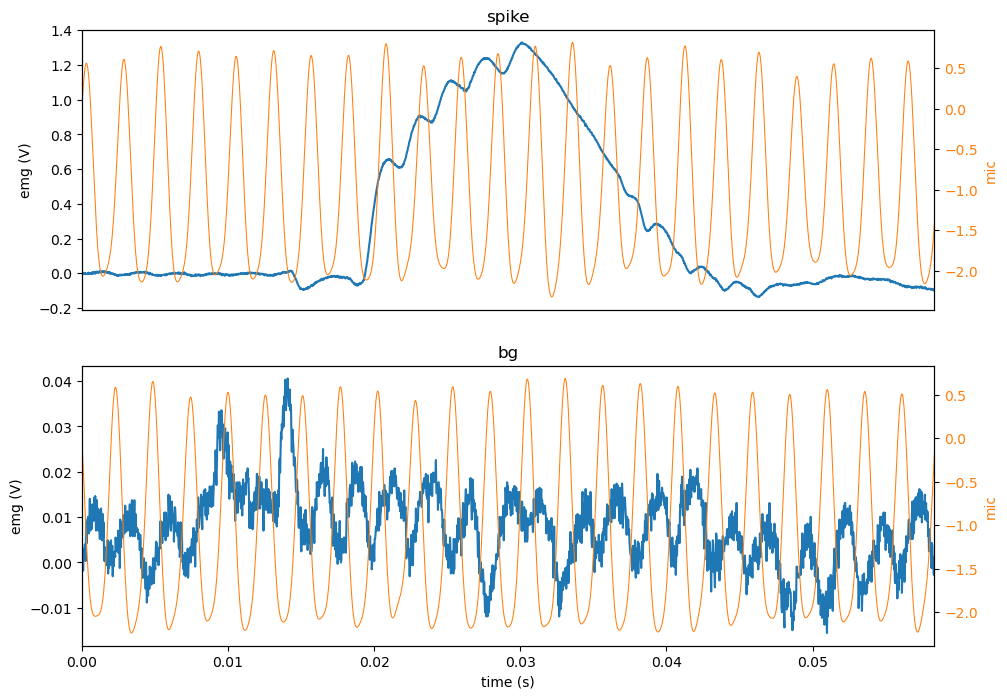

In [123]:
# isolate one example spike
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(11,8))

# for ex_ind in range(len(spike_idx)):
ex_ind = 3
spike_ex_ind = np.arange(spike_idx[ex_ind] - window, spike_idx[ex_ind] + window)
bg_ex_ind = np.arange(spike_idx[ex_ind] - 3*window, spike_idx[ex_ind] - window)
t_window = t[spike_ex_ind] - t[spike_ex_ind][0]

# spike plot
ax1.plot(t_window, emg[spike_ex_ind] - emg[spike_ex_ind][0])  # , lw=0.2, alpha=0.5)
ax11 = ax1.twinx()
color = 'tab:orange'
ax11.plot(t_window, mic_filt[spike_ex_ind] - mic_filt[spike_ex_ind][0], color=color, lw=0.75)
ax11.tick_params(axis='y', labelcolor=color)
ax11.set_ylabel('mic', color=color) 
# ax1.plot(t_window, 0.1*mic_phase[spike_ex_ind], 'r-', lw=0.75) # ax1.plot(t_window, emg_filt[spike_ex_ind], lw=0.75)

# background plot
# ax2.plot(mic_phase[bg_ex_ind], emg[bg_ex_ind], lw=0.25, alpha=0.1)
ax2.plot(t_window, emg[bg_ex_ind] - emg[bg_ex_ind][0])
ax22 = ax2.twinx()
ax22.plot(t_window, mic_filt[bg_ex_ind] - mic_filt[bg_ex_ind][0], color=color, lw=0.75)
ax22.tick_params(axis='y', labelcolor=color)
ax22.set_ylabel('mic', color=color) 

# ax2.plot(t_window, 0.01*mic_phase[spike_ex_ind], 'r-', lw=0.75) 
#ax2.plot(t_window, emg_filt_new[bg_ex_ind])

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_title('spike')
ax1.set_ylabel('emg (V)')
ax1.set_xticks([])

ax2.autoscale(enable=True, axis='x', tight=True)
ax2.set_title('bg')
ax2.set_ylabel('emg (V)')
ax2.set_xlabel('time (s)')
plt.show()

## Get timing of ripple peaks
This will be important both for determining frequency (i.e. is it noise) and deconvolution

Text(0.5, 0, 'time (s)')

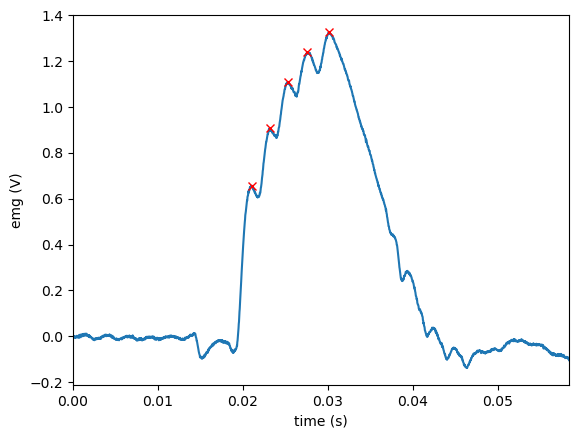

In [124]:
# first find peaks in spike 
waveform_curr = emg[spike_ex_ind] - np.mean(emg[spike_ex_ind][:50])
min_height = 0.3*np.max(waveform_curr )
# min_prominence = 3e-3  # determined empirically 
min_distance = 8
spike_pks, props = signal.find_peaks(waveform_curr , 
                                     distance=min_distance,
                                     height=(min_height, None), 
                                     prominence=(MIN_PROMINENCE, None)) 
# _, spike_pks = get_spike_dt(spike_idx[ex_ind], emg)

# visualize 
fig, ax = plt.subplots()
ax.plot(t_window, waveform_curr )
ax.plot(t_window[spike_pks], waveform_curr[spike_pks], 'rx')

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')
# print(props['prominences'])

Text(0.5, 0, 'time (s)')

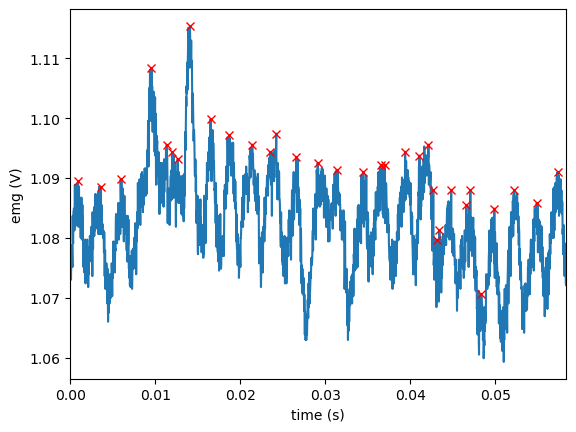

In [125]:
# also try to find peaks for bg signal
bg = emg[bg_ex_ind]
min_height = None  # np.median(bg)
min_prominence = 0.01  # determined empirically 
min_distance = 8 
bg_pks, _ = signal.find_peaks(bg, 
                              distance=min_distance,
                              height=(min_height, None), 
                              prominence=(min_prominence, None)) 

# visualize 
fig, ax = plt.subplots()
ax.plot(t_window, bg)
ax.plot(t_window[bg_pks],bg[bg_pks], 'rx')

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')
# print(props['prominences'])

Text(0.5, 0, 'inter-peak interval')

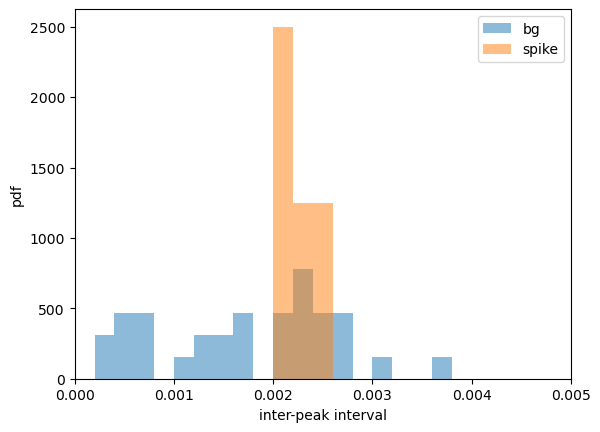

In [126]:
# what is the inter-spike interval for the peaks?
dt_spikes = np.diff(t_window[spike_pks]) 
dt_bg = np.diff(t_window[bg_pks])

bins = np.linspace(0, 0.005, 26)
fig, ax = plt.subplots()
ax.hist(dt_bg, bins=bins, density=True, label='bg', alpha=0.5);
ax.hist(dt_spikes, bins=bins, density=True, label='spike', alpha=0.5);
plt.legend()

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('pdf')
ax.set_xlabel('inter-peak interval')

## Repeat above process across data set

In [127]:
def get_spike_dt(idx, sig, window=window, fs=data['sampling_freq'], debug_flag=True):
    """
    Function to locate peaks in rippling spike and extract time difference between them
    """
    idx_range = np.arange(idx - window, idx + window)
    signal_waveform = sig[idx_range] - np.mean(sig[idx_range][:50]) 
    min_height = 0.3*np.max(signal_waveform)
    min_prominence = 1e-2 * np.max(signal_waveform)
    min_distance = 8
    spike_pks, _ = signal.find_peaks(signal_waveform, 
                                     distance=min_distance,
                                     height=(min_height, None), 
                                     prominence=(min_prominence, None)) 

    if debug_flag:
        prominences = signal.peak_prominences(signal_waveform, spike_pks)[0]
        contour_heights = signal_waveform[spike_pks] - prominences
        fig, ax = plt.subplots()
        ax.plot(signal_waveform)
        plt.plot(spike_pks, signal_waveform[spike_pks], "rx")
        plt.vlines(x=spike_pks, ymin=contour_heights, ymax=signal_waveform[spike_pks], color='r')
        print(prominences)
        plt.show()

    dt_idx = np.diff(spike_pks)
    return (1/fs)*dt_idx, spike_pks

In [128]:
def get_bg_dt(idx_range, sig, fs=data['sampling_freq']):
    """
    Similar to above, but for wiggles in the background signal
    """
    min_height = None  # np.median(bg)
    max_height = 1  # determined empirically
    min_prominence = 0.01  # determined empirically 
    min_distance = 8
    signal_waveform = sig[idx_range] - np.mean(sig[idx_range][:50])
    bg_pks, _ = signal.find_peaks(signal_waveform, 
                                  distance=min_distance,
                                  height=(min_height, max_height), 
                                  prominence=(min_prominence, None)) 

    dt_idx = np.diff(bg_pks)
    return (1/fs)*dt_idx, bg_pks

[0.0549 0.0452 0.0287 0.076  1.42  ]


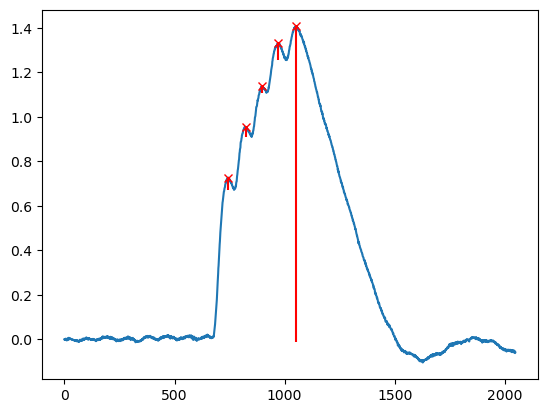

[0.0467 0.0534 0.0369 0.0858 1.4676]


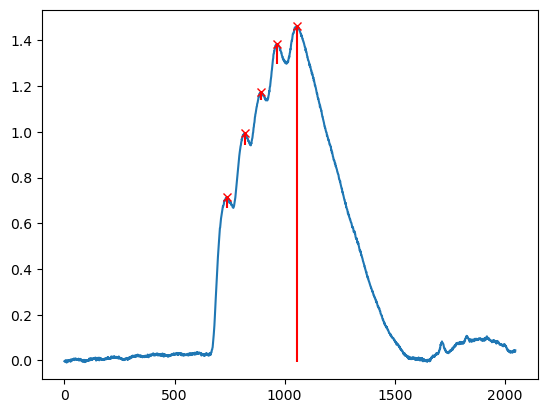

[0.04   0.0494 0.0443 1.2888 0.1517]


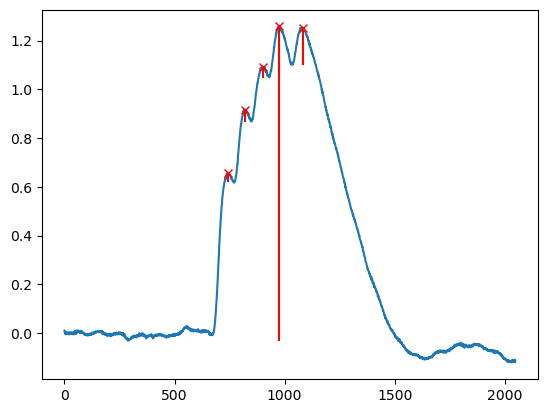

In [129]:
# get dt for all spikes
spike_dt_list = list()
spike_pk_list = list()
for ith, idx in enumerate(spike_idx):
    dt_curr, pks_curr = get_spike_dt(idx, emg)
    spike_dt_list.append(dt_curr)
    # get peak indices so they can be used for full data array
    pks_curr_global = [pk + (idx - window) for pk in pks_curr]
    spike_pk_list.append(pks_curr_global)
    if ith >= 2:
        break
    
spike_dt_all = np.hstack(spike_dt_list)
spike_pk_all = np.hstack(spike_pk_list)
spike_pk_all = spike_pk_all.astype(int)

Text(0.5, 1.0, 'spike wiggle detection')

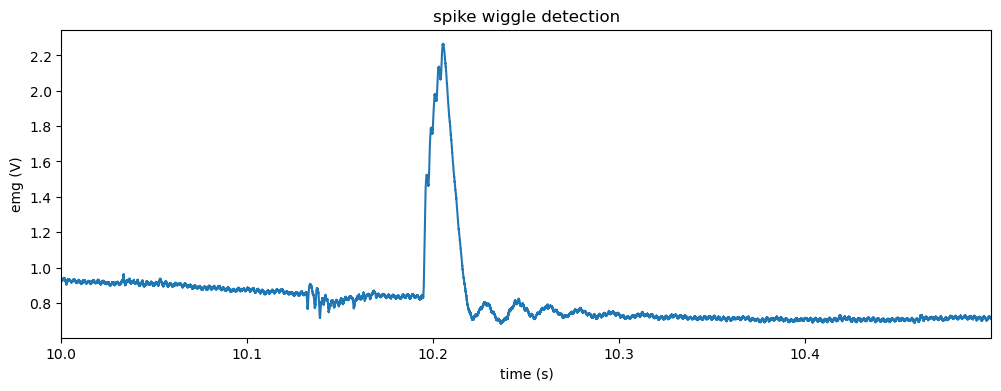

In [130]:
# check spike ripple detection
tmin = 10.0
tmax = 10.5  # 10.7
mask = (t >= tmin) & (t <= tmax)
mask_pks = (t[spike_pk_all] >= tmin) & (t[spike_pk_all] <= tmax)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t[mask], emg[mask])
ax.plot(t[spike_pk_all][mask_pks], emg[spike_pk_all][mask_pks], 'rx')

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')
ax.set_title('spike wiggle detection')


In [131]:
# get dt for all bg peaks (wiggles)
spike_idx_log = np.zeros(emg.shape, dtype=bool)
for idx in spike_idx:
    spike_range = np.arange(idx - data['params']['emg_window'], idx + data['params']['emg_window']) 
    spike_idx_log[spike_range] = True

bg_idx_log = ~spike_idx_log
bg_idx_list = idx_by_thresh(bg_idx_log)

bg_dt_list = list()
bg_pk_list = list()
for idx in bg_idx_list:
    dt_curr, pks_curr = get_bg_dt(idx, emg)
    bg_dt_list.append(dt_curr)
    # get peak indices so they can be used for full data array
    pks_curr_global = [pk + idx[0] for pk in pks_curr]
    bg_pk_list.append(pks_curr_global)
    
bg_dt_all = np.hstack(bg_dt_list)
bg_pk_all = np.hstack(bg_pk_list).astype(int)

Text(0.5, 1.0, 'bg wiggle detection')

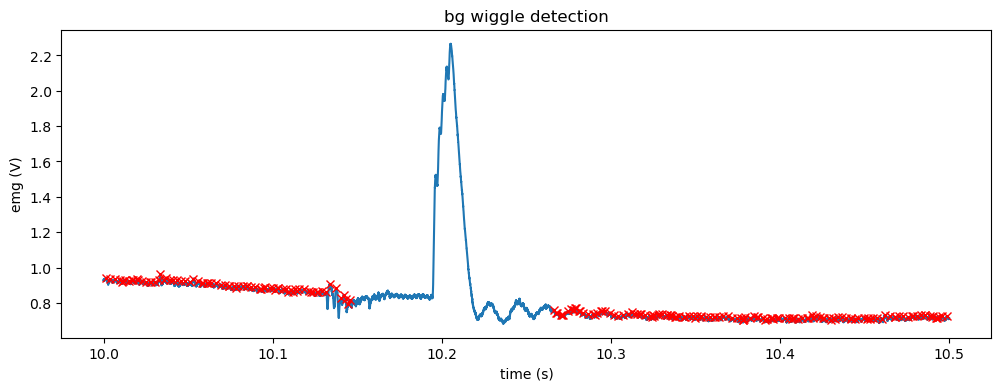

In [132]:
# check bg wiggle detection
# check spike ripple detection
tmin = 10.0
tmax = 10.5
mask = (t >= tmin) & (t <= tmax)
mask_pks = (t[bg_pk_all] >= tmin) & (t[bg_pk_all] <= tmax)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t[mask], emg[mask])
ax.plot(t[bg_pk_all][mask_pks], emg[bg_pk_all][mask_pks], 'rx')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')
ax.set_title('bg wiggle detection')


Text(0.5, 0, 'inter-peak interval')

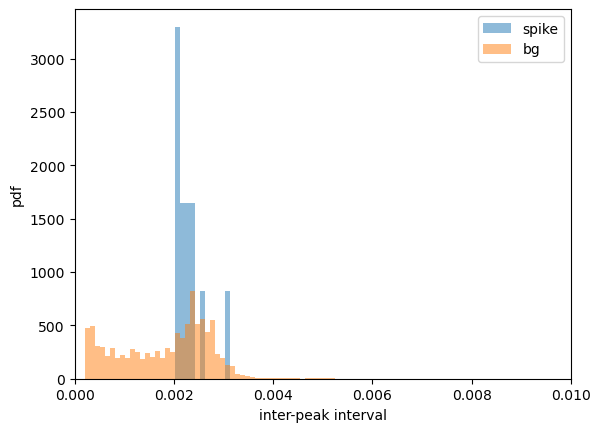

In [133]:
# visualize histograms
fig, ax = plt.subplots()

bins = np.linspace(0, 0.01, 100)
ax.hist(spike_dt_all, bins=bins, density=True, alpha=0.5, label='spike');
ax.hist(bg_dt_all, bins=bins, density=True, alpha=0.5, label='bg');
plt.legend()

ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('pdf')
ax.set_xlabel('inter-peak interval')

In [134]:
# dt, pks = get_bg_dt(bg_ex_ind, emg)
# print(dt)
# print(dt_bg)

## Align spikes to rise threshold

Although I'm not exactly sure how this should be defined...

In [135]:
# loop through and align spikes to new threshold
spikes_realigned = list()
spike_realigned_idx = list()
thresh =0.5 # 0.1  # 1

for idx in spike_idx:
    # get spike in current window
    idx_range = np.arange(idx - window, idx + window)
    spike = emg[idx_range]

    # subtract off value at initial time point
    spike -= spike[0]

    # find first instance of thresh crossing
    try:
        thresh_idx = np.where(spike > thresh)[0][0]
    except IndexError:
        continue
        
    thresh_idx += (idx - window)
    spike_realigned_idx.append(thresh_idx)

    # get spike in this new window
    spike_new = emg[slice(thresh_idx - window, thresh_idx + 2*window)]
    # spike_new -= spike_new[0]
    spikes_realigned.append(spike_new)
    

Text(0.5, 0, 'time (s)')

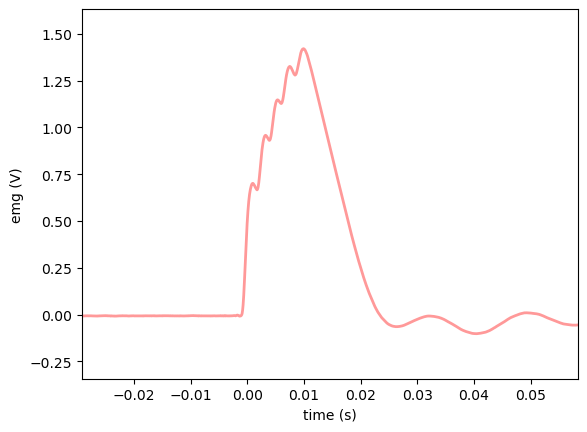

In [136]:
# plot spikes aligned by rise time thresh
fig, ax = plt.subplots()

# define time range
t_win = (1/fs)*(np.arange(spikes_realigned[0].shape[0]) - window)

# plot spikes
spike_mean = np.zeros(spikes_realigned[0].shape)
for spike in spikes_realigned:
    ax.plot(t_win, spike - np.mean(spike[:window]), 'w-', alpha=0.2, lw=0.1)
    spike_mean += spike - np.mean(spike[:window])

ax.plot(t_win, spike_mean/len(spikes_realigned), 'r-', alpha=0.4, lw=2)

# label axes
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')


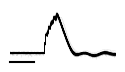

In [137]:
# FORMATTED plot spikes aligned by rise time thresh
fig, ax = plt.subplots(figsize=(1.365, 0.683))

# define time range
t_win = (1/fs)*(np.arange(spikes_realigned[0].shape[0]) - window)

# plot spikes
spike_mean = np.zeros(spikes_realigned[0].shape)
for spike in spikes_realigned:
    ax.plot(t_win, spike - np.mean(spike[:window]), 'k-', alpha=0.2, lw=0.1)
    spike_mean += spike - np.mean(spike[:window])


# axis formatting
ax.autoscale(enable=True, axis='x', tight=True)
ax.tick_params(direction='in', length=0)
# ax.set_xlabel('time (s)')

ax.set_yticks([])
ax.set_xticks([])
scalebar_bounds = [np.min(t_win), np.min(t_win) + 0.02]

ax.spines['bottom'].set_bounds((scalebar_bounds))
ax.spines['bottom'].set_linewidth(1.5)

for spine in ['right', 'top', 'left']:
    ax.spines[spine].set_visible(False)

# save
save_path = '/home/sam/Desktop/{}_{:02d}_aligned_bursts.svg'.format(data_folder, axo_num)
fig.savefig(save_path)


In [112]:
# if i took a guess at modeling noise process, what would it look like?

## Look at distribution of inter-spike intervals for different spike numbers

e.g. Michael says that the time between spikes 1 and 2 should be greater than the time between 2 and 3

(array([ 11.,   0.,   0.,   0.,   0., 205.,   0.,   0.,   0.,   4.]),
 array([4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. ]),
 <BarContainer object of 10 artists>)

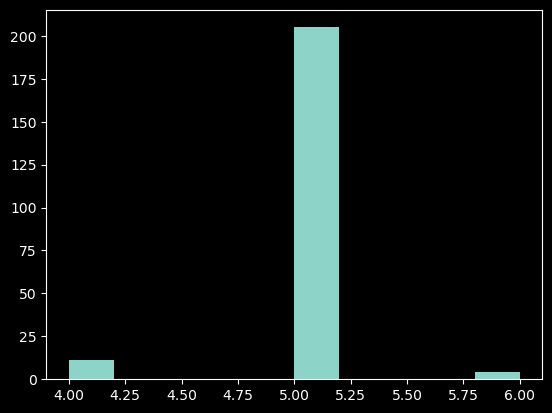

In [83]:
# take advantage of the spike list we already have
spike_pk_diff_list = list()

for pks in spike_pk_list:
    pks_diff = np.diff(pks)
    # for now, make sure we only have 'bursts' with 4-5 spikes
    if (pks_diff.size < 7):
        # while pks_diff.size < 4:
        #     pks_diff = np.insert(pks_diff, pks_siff.size, -1)
        spike_pk_diff_list.append(pks_diff)

lengths = [len(pks) for pks in spike_pk_diff_list]
plt.hist(lengths)


In [84]:
# pull out different inter-peak intervals
hist_data = list()
hist_labels = list()
# get 1-2, 2-3, 3-4, 4-5
for ind in range(4):
    pk_diff_arr = np.asarray([pk_diff[ind] for pk_diff in spike_pk_diff_list if pk_diff.size > ind])
    hist_data.append((1/fs)*pk_diff_arr)
    label_str = '{} to {}'.format(ind+1, ind+2)
    hist_labels.append(label_str)
    
# hist_labels = ['1st - 2nd', '2nd - 3rd', '3rd - 4th', '4th - 5th'] 

Text(0.5, 0, 'inter-peak interval (ms)')

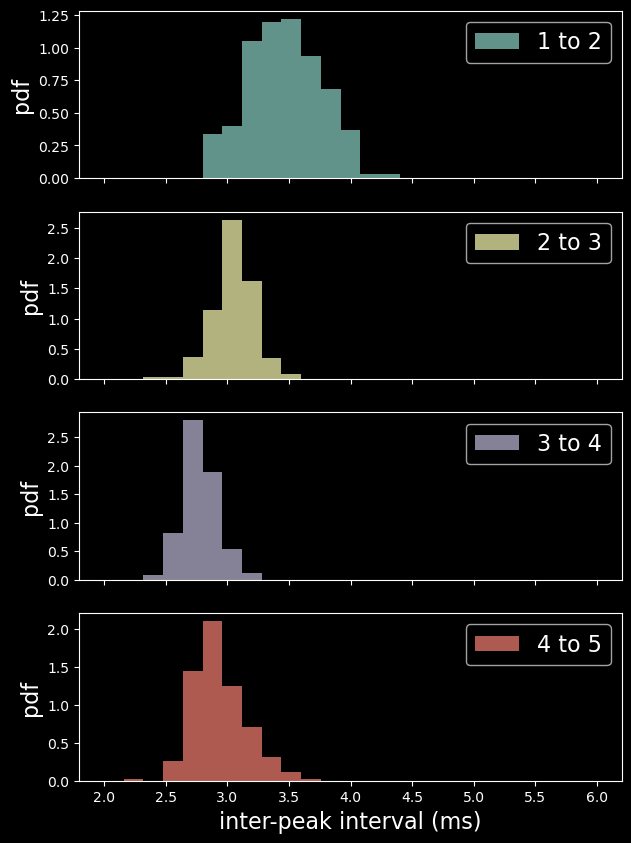

In [85]:
# make histogram of results
fig, ax_list = plt.subplots(len(hist_data), 1, figsize=(7, 10), sharex=True)
ax_list = ax_list.ravel()
bins = 1000*np.linspace(0.002, 0.006, 26)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ith, (label, hdata) in enumerate(zip(hist_labels, hist_data)):
    ax_list[ith].hist(1000*hdata, bins=bins, density=True, alpha=0.7, label=label, color=colors[ith]) #  fill=False, histtype='step', lw=2);
    ax_list[ith].set_ylabel('pdf')
    ax_list[ith].legend(fontsize=16)
    
ax_list[ith].autoscale(enable=True, axis='x', tight=True)
ax_list[ith].set_xlabel('inter-peak interval (ms)')

## Where are the 4 vs 5 spike events?

In [89]:
# find indices for 4 and 5 spike events
spike_dt_lengths = np.asarray([s.size for s in spike_dt_list])
n_spike_idx = list()
for n_spikes in range(8):
    nsi = spike_idx[spike_dt_lengths == (n_spikes - 1)]
    n_spike_idx.append(nsi)
    

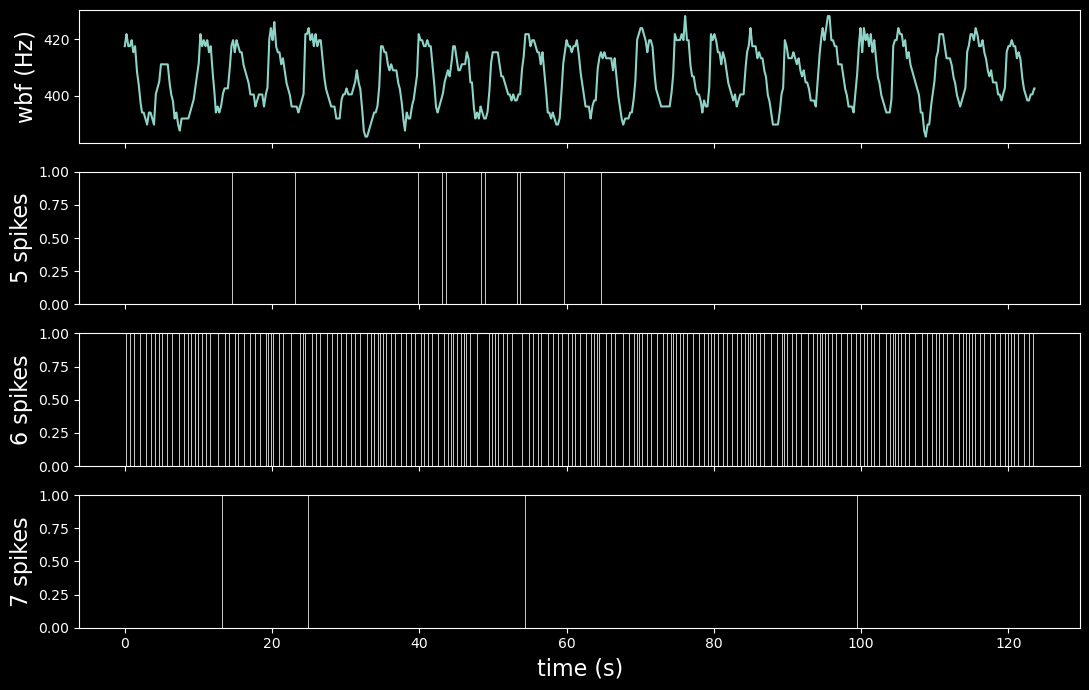

In [91]:
# plot these data as raster plots, along with wbf
spike_nums = [5, 6, 7]
fig, ax_list = plt.subplots(len(spike_nums)+1,1,figsize=(11, 7), sharex=True)
ax_list = ax_list.ravel()

# first plot wbf
ax_list[0].plot(t, wbf)
ax_list[0].set_ylabel('wbf (Hz)')
# ax_list[0].set_ylim([400, 450])

# then spike frequencies
for ith, n_spikes in enumerate(spike_nums):
    for sidx in n_spike_idx[n_spikes]:
        ax_list[ith+1].axvline(t[sidx], color='w', lw=0.55)
    ax_list[ith+1].set_ylabel('{} spikes'.format(n_spikes))
       
ax_list[ith+1].autoscale(enable=True, axis='x', tight=True) 
ax_list[ith+1].set_xlabel('time (s)')
fig.tight_layout()

## Timing of final spike relative to penultimate

In [115]:
# make new arrays of burst timing and ultimate - penultimate spike timing for just most frequent spike number
tmp_spike_idx = list()
final_spike_timing = list()

# get mode spike number
vals, counts = np.unique(lengths, return_counts=True)
mode_spike_num = vals[np.argmax(counts)]

# loop over spikes to collect data
for ith, dt_list in enumerate(spike_dt_list):
    if len(dt_list) == mode_spike_num:
        tmp_spike_idx.append(spike_idx[ith])
        final_spike_timing.append(sum(dt_list))
        # final_spike_timing.append(dt_list[-1])


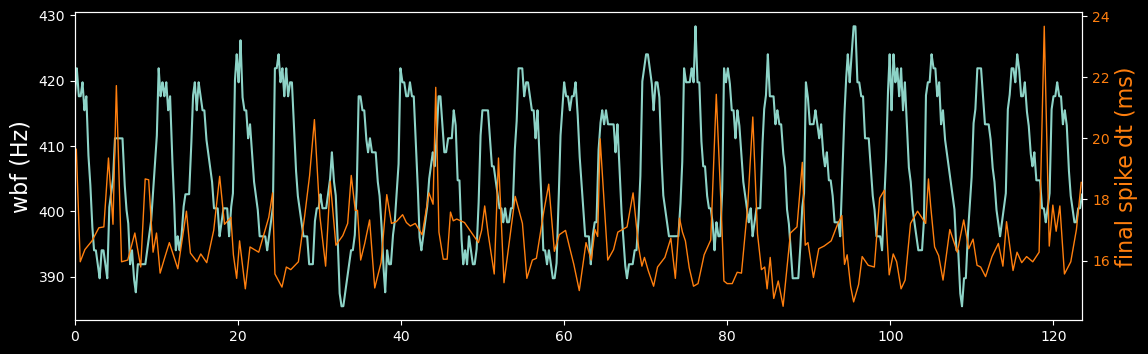

In [118]:
# visualize
fig, ax0 = plt.subplots(figsize=(13,4), sharex=True)

# first plot wbf
ax0.plot(t, wbf)
ax0.set_ylabel('wbf (Hz)')

ax1= ax0.twinx()
color = 'tab:orange'
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('final spike dt (ms)', color=color) 
# then plot timing of last spike
tmp_t = np.asarray([t[sidx] for sidx in tmp_spike_idx])
ax1.plot(tmp_t, 1000*np.asarray(final_spike_timing), '-', lw=1, color=color)

# set axis props
ax0.autoscale(enable=True, axis='x', tight=True) 
ax1.autoscale(enable=True, axis='x', tight=True) 

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(t, wbf)